In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
apps = pd.read_csv('Apps Data.csv')

In [48]:
print(apps)

      Downloads       Revenue                 Category  In_App_Purchases  \
0      14025020  3.814998e+08                   Action              True   
1      47626428  3.087616e+08                   Casual              True   
2      59717242  3.068476e+08                Lifestyle              True   
3       9644402  2.696603e+08             Role Playing              True   
4      36942437  1.984544e+08            Music & Audio              True   
5      71314720  1.623006e+08  Video Players & Editors              True   
6      37779102  1.259392e+08                   Casual              True   
7      60991823  1.184065e+08                Adventure              True   
8      33519732  1.114186e+08                     Card              True   
9      32797250  1.097406e+08                   Casual              True   
10     14686144  1.093629e+08                     Card              True   
11    128434634  9.740574e+07                   Sports              True   
12     40143

In [4]:
print('Rows: {}, Cols: {}'.format(apps.shape[0], apps.shape[1]))

Rows: 1466, Cols: 6


In [5]:
apps.dtypes

Downloads             int64
Revenue             float64
Category             object
In_App_Purchases       bool
Ads                    bool
Free                   bool
dtype: object

In [6]:
apps.isnull().sum()

Downloads           0
Revenue             0
Category            0
In_App_Purchases    0
Ads                 0
Free                0
dtype: int64

I have no null values. This is good.

In [7]:
ax = apps.plot(kind='scatter', x='Downloads', y='Revenue');
ax.set_title('Apps Revenue vs. Downloads');

In [8]:
apps.describe()

,Downloads,Revenue
count,1.466000e+03,1.466000e+03
mean,2.228502e+07,1.028029e+07
std,3.374783e+07,4.729205e+07
min,7.281799e+06,0.000000e+00
25%,9.194319e+06,0.000000e+00
50%,1.260039e+07,2.347047e+04
75%,2.242162e+07,1.306151e+06
max,7.502986e+08,6.735595e+08


I see here that there are apps with 0 revenue. I will need to eliminate those to be able to compare apps across those that does generate revenue. Some developers could be uninterested in making apps for revenue.

In [9]:
apps.loc[:,'Free'].value_counts()

True     1464
False       2
Name: Free, dtype: int64

Text(0.5,1,'Number of Apps That Are Free vs. Paid')

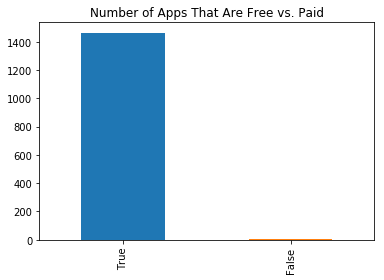

In [10]:
ax = apps.loc[:, 'Free'].value_counts().plot(kind='bar')
ax.set_title('Number of Apps That Are Free vs. Paid')

Among the given apps in this data set of 1,466 apps, only two of them were not free, meaning they charge users to download. Since there is only two paid apps, I am going to keep the scope of this study within free apps.

The next steps I will take for the sake of simplying is to: 

(1) Remove paid app, which would be indicated by the value in column "Free" = "False"
(2) Remove non-revenue generating apps, which would have value in "Revenue" column equal 0. 

In [11]:
apps.loc[:,'Ads'].value_counts()

True     1120
False     346
Name: Ads, dtype: int64

Text(0.5,1,'Number of Apps That Are Ad-Supported')

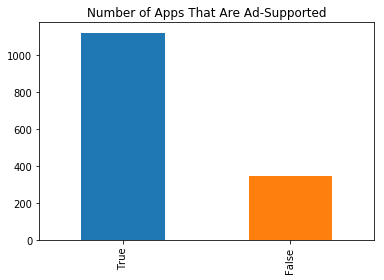

In [12]:
ax = apps.loc[:, 'Ads'].value_counts().plot(kind='bar')
ax.set_title('Number of Apps That Are Ad-Supported')

In [13]:
apps.loc[:,'In_App_Purchases'].value_counts()

True     848
False    618
Name: In_App_Purchases, dtype: int64

Text(0.5,1,'Number of Apps Sell In-App Purchases')

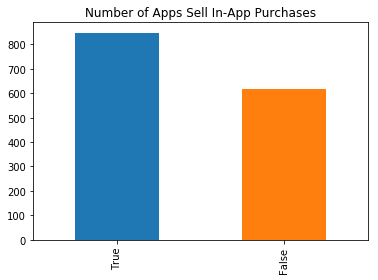

In [14]:
ax = apps.loc[:, 'In_App_Purchases'].value_counts().plot(kind='bar')
ax.set_title('Number of Apps Sell In-App Purchases')

Since the number of apps containing ads and the number of apps with in-app purchases are not complementary, that means some apps are overlapping. For the study, I will need to run linear regressions across three different data frames filtered on this categories:

(1) In_App_Purchases = True & Ads = False
(2) In App_Purchases = False & Ads = True
(3) In App_Purchases = True & Ads = True

# Action #1 Create a Data Frame that Only Contains Paid-For Apps with Revenue > 0

In [15]:
apps_data = apps.loc[apps.loc[:,'Revenue']>0]

In [16]:
apps_data.describe()

,Downloads,Revenue
count,8.980000e+02,8.980000e+02
mean,2.342826e+07,1.678275e+07
std,3.595969e+07,5.952740e+07
min,7.283067e+06,4.800000e+00
25%,9.339326e+06,4.871161e+04
50%,1.310063e+07,5.421269e+05
75%,2.432318e+07,5.750781e+06
max,7.502986e+08,6.735595e+08


In [17]:
apps_data = apps_data.loc[apps_data.loc[:,'Free']==True]
apps_data.loc[:,'Free'].value_counts()

True    896
Name: Free, dtype: int64

# Action #2 Create Three Different Groups on Which to Run Three Separate Models 

In [18]:
ads_only = apps_data.loc[(apps_data['Ads']==True) & (apps_data['In_App_Purchases']==False),:]

In [19]:
print(ads_only)

      Downloads       Revenue           Category  In_App_Purchases   Ads  Free
848   193644369  8.952401e+07      Entertainment             False  True  True
849   154024472  8.878442e+07      Music & Audio             False  True  True
850    11135010  8.158926e+07              Board             False  True  True
851    18808376  5.606227e+07      Entertainment             False  True  True
852    31200767  4.107877e+07             Social             False  True  True
853    65089652  2.712085e+07      Music & Audio             False  True  True
854    86064787  2.395476e+07      Communication             False  True  True
855    25321806  1.532386e+07      Music & Audio             False  True  True
856    32442147  1.182210e+07             Social             False  True  True
857   269873697  4.919016e+06      Communication             False  True  True
858    54661279  4.595263e+06             Arcade             False  True  True
859    37919355  2.164668e+06      Music & Audio    

In [20]:
ads_only.shape

(79, 6)

In [21]:
inapppurchase_only = apps_data.loc[(apps_data['Ads']==False) & (apps_data['In_App_Purchases']==True),:]

In [22]:
inapppurchase_only.shape

(133, 6)

In [23]:
ads_and_purchase = apps_data.loc[(apps_data['Ads']==True) & (apps_data['In_App_Purchases']==True),:]

In [24]:
ads_and_purchase.shape

(684, 6)

Here, I now have three data sets: Ads Only, In-App-Purchase Only, and Ads and In-App Purchases, all of which have greater than $0 in revenue in 2017 and are all free to download.

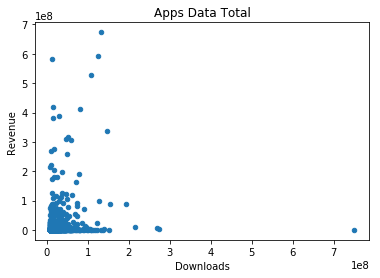

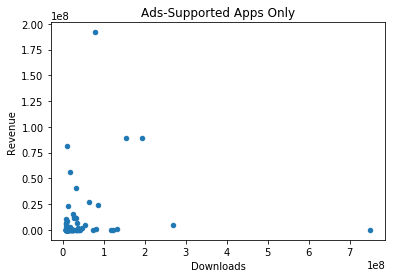

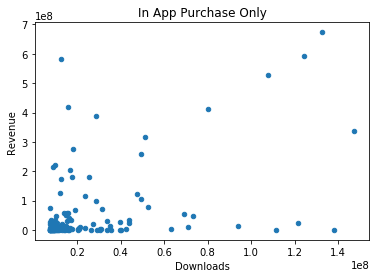

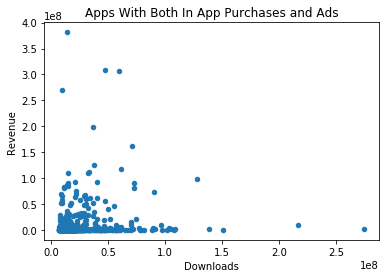

In [25]:
ax1 = apps_data.plot(kind='scatter', x='Downloads', y='Revenue', title = 'Apps Data Total');
ax2 = ads_only.plot(kind='scatter', x='Downloads', y='Revenue', title = 'Ads-Supported Apps Only');
ax3 = inapppurchase_only.plot(kind='scatter', x='Downloads', y='Revenue', title = 'In App Purchase Only');
ax4 = ads_and_purchase.plot(kind='scatter', x='Downloads', y='Revenue', title = 'Apps With Both In App Purchases and Ads');

# Action #3 Develop a linear regression model to predict revenue for each business type

I plan to train the models on 70% of the data.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Ads Only Dataset

In [27]:
X = ads_only.loc[:, ['Downloads']]
y = ads_only.loc[:,'Revenue']

In [28]:
lr = LinearRegression()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
len(X_train), len(X_test)

(55, 24)

In [33]:
lrl = linear_model.LinearRegression()
lrl.fit(X_train, y_train)
ads_only_y_pred = lrl.predict(X_test)

print('Coefficients: ', lrl.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, ads_only_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, ads_only_y_pred))

Coefficients:  [0.02935242]
Mean squared error: 368808136543025.25
Variance score: 0.05


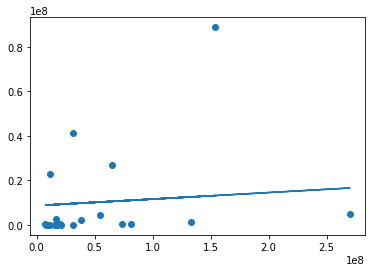

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(X_test, y_test)
plt.plot(X_test, ads_only_y_pred)

The data doesn't fit too well. There is very high bias, as well as variance. A bigger data set could help with variance in the future.

Only 5% of the difference in app revenue is explained by the difference in downloads and the MSE is very large.

# In-App Purchase Only

In [34]:
A = inapppurchase_only.loc[:, ['Downloads']]
b = inapppurchase_only.loc[:,'Revenue']

In [35]:
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.3)
len(A_train), len(A_test)

(93, 40)

In [36]:
lrl.fit(A_train, b_train)
inapppurchase_only_b_pred = lrl.predict(A_test)

print('Coefficients: ', lrl.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(b_test, inapppurchase_only_b_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(b_test, inapppurchase_only_b_pred))

Coefficients:  [1.12278774]
Mean squared error: 25075873945490164.00
Variance score: 0.22


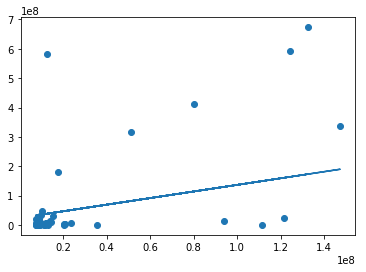

In [45]:
plt.scatter(A_test, b_test)
plt.plot(A_test, inapppurchase_only_b_pred)

The data doesn't fit too well. There is very high bias, as well as variance. A bigger data set could help with variance in the future.

Only 22% of the difference in app revenue is explained by the difference in downloads, which is better than the previous data set, but the MSE is still very large, showing that this model with Downloads as the independent variable doesn't do a good job at predicting revenue.

# Both Ads and In-App Purchases

In [38]:
B = ads_and_purchase.loc[:, ['Downloads']]
k = ads_and_purchase.loc[:,'Revenue']

In [39]:
B_train, B_test, k_train, k_test = train_test_split(B, k, test_size=0.3)
len(B_train), len(B_test)

(478, 206)

In [40]:
lrl.fit(B_train, k_train)
ads_and_purchase_k_pred = lrl.predict(B_test)

print('Coefficients: ', lrl.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(k_test, ads_and_purchase_k_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(k_test, ads_and_purchase_k_pred))

Coefficients:  [0.1574497]
Mean squared error: 785800783133758.62
Variance score: 0.04


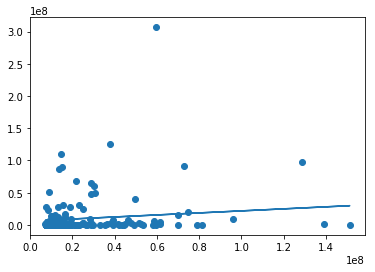

In [46]:
plt.scatter(B_test, k_test)
plt.plot(B_test, ads_and_purchase_k_pred)

The data doesn't fit too well. There is very high bias, as well as variance. A bigger data set could help with variance in the future.

Only 4% of the difference in app revenue is explained by the difference in downloads and the MSE is very large.

# Conclusions

My models predicting app revenue from app downloads proved to be inaccurate and useless, with very low acccuracy. This is valuable insight that shows that the number of downloads isn't the core driver of app revenue, regardless of the business model.

Other variables not available in my data set is likely driving app revenue. In the future, we could look at:

(1) App Category
(2) Time Spent in-app